In [ ]:
# 1. Right 공정 제거
# 2. Lower 공정 제거

# 3. 의미 없는 열 제거
# 3-1. 분산 0.01 미만인 열 제거
# 3-2. 다중 공선성 제거 - 상관 계수 0.9 이상인 경우 / VIF > 10

# 4. Robust Scaler

# 5. 차원 축소 및 군집

# 최종 last_df > (8143, 119)

# ** 시각화로 열 제거 - 분산 < 0.025 & 타겟과의 상관 계수 < 0.1 & 시각화에서 타겟과 연관 없어보임 


In [11]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

In [114]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture


In [2]:
preprocessed_df = pd.read_csv('../data/preprocessed_df.csv', index_col= 0)
preprocessed_df.info() # (8143, 833)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 833 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(827), int64(6)
memory usage: 51.8+ MB


## 1. Right 피쳐 제거

- Left, Right 상관 계수 확인

- Left, Right t-test

- Left, Right 히트맵

- Right 공정 열 제거

In [ ]:
column_list = preprocessed_df.columns.tolist()
# column_list

#.LEFT.  ,  Left.  , .L., _U_L, _L_L, _L_
#.RIGHT. ,  Right. , .R., _U_R, _L_R, _R_
# UPPER. , _U_L, _U_R, _U_
# LOWER. , _L_L, _L_R, _L_

# LEFT, RIGHT 이름의 공정 중 LEFT,RIGHT만 다르고 공정명 동일 - 중요 공정 파악 문제이므로 둘 중 하나만 남김
# UPPER, LOWER은 공정의 비가 동일하지 않아 다른 공정일 수 있음

### 1-1. Left, Right 상관 계수 확인

In [44]:
# 1) left, right 쌍 상관 계수
left_cols = preprocessed_df.filter(regex=r'\b(LEFT|Left|L\.|l_|_L)\b').columns.tolist()
right_cols = preprocessed_df.filter(regex=r'\b(RIGHT|Right|R\.|r_|_R)\b').columns.tolist()

# LEFT와 RIGHT 열을 매칭하기 위한 딕셔너리 생성
left_right_pairs = {}

# LEFT 열 이름 처리
for left_col in left_cols:
    # 숫자를 제외하고 동일한 열 쌍으로 생성
    process_id = re.sub(r'(\.L\.|L\.|LEFT|l_|_L|\d+)', '', left_col, flags=re.IGNORECASE) # 수치를 제외한 나머지가 동일, re.IGNORECASE : 대소문자 구별없음
    if process_id not in left_right_pairs:
        left_right_pairs[process_id] = {'left': left_col, 'right': None}
    else:
        left_right_pairs[process_id]['left'] = left_col

# RIGHT 열 이름 처리
for right_col in right_cols:
    process_id = re.sub(r'(\.R\.|R\.|RIGHT|r_|_R|\d+)', '', right_col, flags=re.IGNORECASE)
    if process_id not in left_right_pairs :
        left_right_pairs[process_id] = {'left': None, 'right': right_col}
    else:
        left_right_pairs[process_id]['right'] = right_col

left_right_pairs # dict {process_id : {'left' : 'Left_process_id}, {'right' : 'Right_process_id}}

correlation_results = []

for process_id, col in left_right_pairs.items():
    left_col = col['left']
    right_col = col['right']

    if left_col in preprocessed_df.columns and right_col in preprocessed_df.columns:
        correlation = preprocessed_df[left_col].corr(preprocessed_df[right_col])
        correlation_results.append((left_col, right_col, correlation))


correlation_results = sorted(correlation_results, key=lambda x: abs(x[2]), reverse=True)
correlation_results # 22개개

[('DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV',
  'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV',
  0.9987756979261998),
 ('DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV.1',
  'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV.1',
  0.9985293343641684),
 ('DROSSBOX.N2.SCN.L.1JI39011_PV',
  'DROSSBOX.N2.SCN.R.1JI39012_PV',
  0.995600511240022),
 ('RET.AMBIANT.LEFT.TMP.1TI42602.PV',
  'RET.AMBIANT.RIGHT.TMP.1TI42603.PV',
  0.9916315797841909),
 ('EXIT.LIP.PLATE.LEFT.1TI30604.PV',
  'EXIT.LIP.PLATE.RIGHT.1TI30605.PV',
  0.9571435823739101),
 ('DROSS.BOX.N2.BTM.HT1.L.1JI39005.PV',
  'DROSS.BOX.N2.BTM.HT1.R.1JI39006.PV',
  0.9377374476619134),
 ('TMP.TIN..BAY.10.LEFT.1TI30209.PV',
  'TMP.TIN..BAY.10.RIGHT.1TI30210.PV',
  0.8772713031600036),
 ('투입.LEFT.', '투입.RIGHT.', 0.8396554789987675),
 ('SPOUT.LEFT.BOS.UPSTREAM.1FI33512.PV',
  'SPOUT.RIGHT.BOS.UPSTREAM.1FI33517.PV',
  0.8210989902249686),
 ('SPOUT.LEFT.TOP.1FI33514.PV',
  'SPOUT.RIGHT.TOP.1FI33519.PV',
  0.7141663175098149),
 ('X.7.BAY.LEFT.PRESSURE.1CLBAY7LEFT_CPV',
  'X.7.BAY

In [56]:
# left_cols
# right_cols
# left_right_pairs

In [58]:
# 결과를 DataFrame으로 변환
correlation_df = pd.DataFrame(correlation_results, columns=['Left_col', 'Right_col', 'Correlation'])

# 쌍 상관계수 결과 확인
correlation_df

correlation_drop_r_cols = correlation_df[abs(correlation_df['Correlation']) >= 0.8]['Right_col'].tolist()
correlation_drop_r_cols

['DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV',
 'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV.1',
 'DROSSBOX.N2.SCN.R.1JI39012_PV',
 'RET.AMBIANT.RIGHT.TMP.1TI42603.PV',
 'EXIT.LIP.PLATE.RIGHT.1TI30605.PV',
 'DROSS.BOX.N2.BTM.HT1.R.1JI39006.PV',
 'TMP.TIN..BAY.10.RIGHT.1TI30210.PV',
 '투입.RIGHT.',
 'SPOUT.RIGHT.BOS.UPSTREAM.1FI33517.PV']

### 1-2. Left, Right t-test

In [30]:
# p_value > 0.05 : 동일한 분포를 가질 가능성이 높음

ttest_result = []

for l_col, r_col in zip(left_cols, right_cols):
    t_stat, p_value = ttest_ind(preprocessed_df[l_col].dropna(), preprocessed_df[r_col].dropna())
    ttest_result.append((l_col, r_col, p_value))

ttest_df = pd.DataFrame(ttest_result, columns= ['Left_col', 'Right_col', 'p_value'])
ttest_df

ttest_drop_r_cols = ttest_df[ttest_df['p_value'] <= 0.05]['Right_col'].to_list()
ttest_drop_r_cols

['TMP.TIN..BAY.5.RIGHT.1TI30206.PV',
 '투입.RIGHT.',
 'ROLLDOWN.폐기.RIGHT.',
 '진공패드.폐기.RIGHT.',
 'ROLLDOWN.진공패드.폐기율..RIGHT.',
 'R.RD',
 'R.Vac']

### 1-3. 상관관계, t-test 결과 기반 열 삭제 

In [39]:
preprocessed_df.info() # (8143, 833)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 833 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(827), int64(6)
memory usage: 51.8+ MB


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# drop list - correlation, ttest
print(len(correlation_drop_r_cols)) # 9
print(len(ttest_drop_r_cols)) # 7

total_drop_r_cols = correlation_drop_r_cols + ttest_drop_r_cols
total_drop_r_cols = set(total_drop_r_cols)
print(total_drop_r_cols)
print(len(total_drop_r_cols)) # 15

drop_right_df = preprocessed_df.loc[:, ~preprocessed_df.columns.isin(total_drop_r_cols)]
drop_right_df.info() #(8143, 818) num_col : 833 > 818

9
7
{'투입.RIGHT.', '진공패드.폐기.RIGHT.', 'TMP.TIN..BAY.10.RIGHT.1TI30210.PV', 'ROLLDOWN.진공패드.폐기율..RIGHT.', 'TMP.TIN..BAY.5.RIGHT.1TI30206.PV', 'RET.AMBIANT.RIGHT.TMP.1TI42603.PV', 'SPOUT.RIGHT.BOS.UPSTREAM.1FI33517.PV', 'R.RD', 'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV', 'DROSSBOX.N2.SCN.R.1JI39012_PV', 'ROLLDOWN.폐기.RIGHT.', 'R.Vac', 'EXIT.LIP.PLATE.RIGHT.1TI30605.PV', 'DROSS.BOX.N2.BTM.HT1.R.1JI39006.PV', 'DB.N2.SCREEN.FLOW.RIGHT.1FI49012_PV.1'}
15
<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 818 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(815), int64(3)
memory usage: 50.9+ MB


In [ ]:
# right열 전체 삭제 코드)

# preprocessed_df.select_dtypes(object) # 날짜
# 그 외 데이터는 모두 수치형 데이터

# left_right_cols = preprocessed_df.filter(regex=r'\b(LEFT|RIGHT|Left|Right|L\.|R\.|l_|r_|_L|_R)\b').columns.tolist()
# print(len(left_right_cols))
# # for column in left_right_cols :
# #   print(column) # 71

# right_drop_cols = preprocessed_df.filter(regex=r'\b(RIGHT|Right|R\.|r_|_R)\b').columns.tolist()
# print(len(right_drop_cols))
# # for col in right_drop_cols :
# #   print(col) # 34

# print()
# drop_right_df = preprocessed_df.loc[:, ~preprocessed_df.columns.isin(right_drop_cols)]
# drop_right_df.info() 
# # 833 > 799열

### 1-4. LEFT, RIGHT 개별 히트맵 시각화

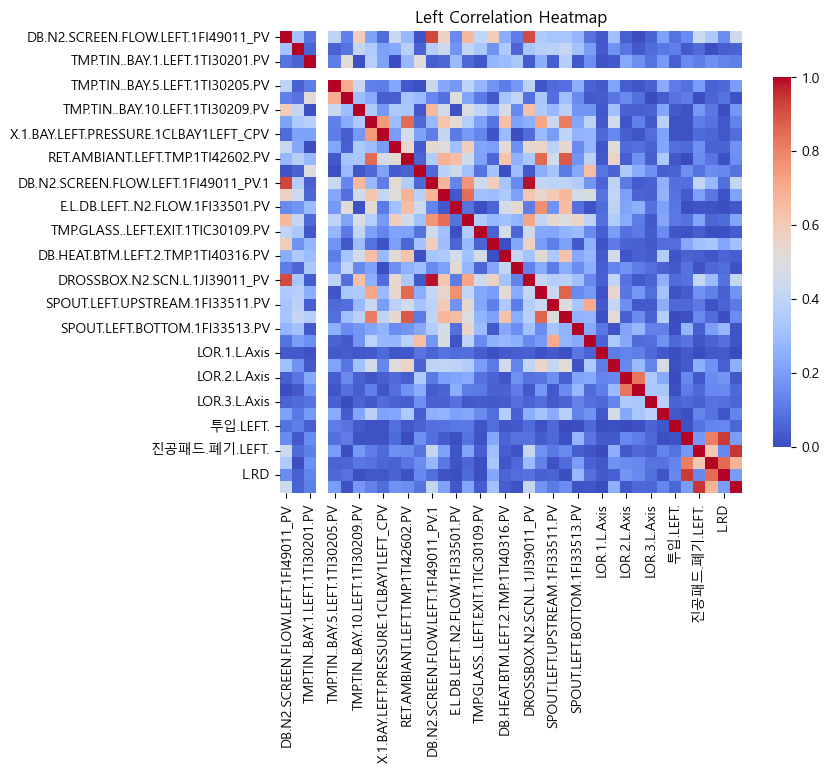

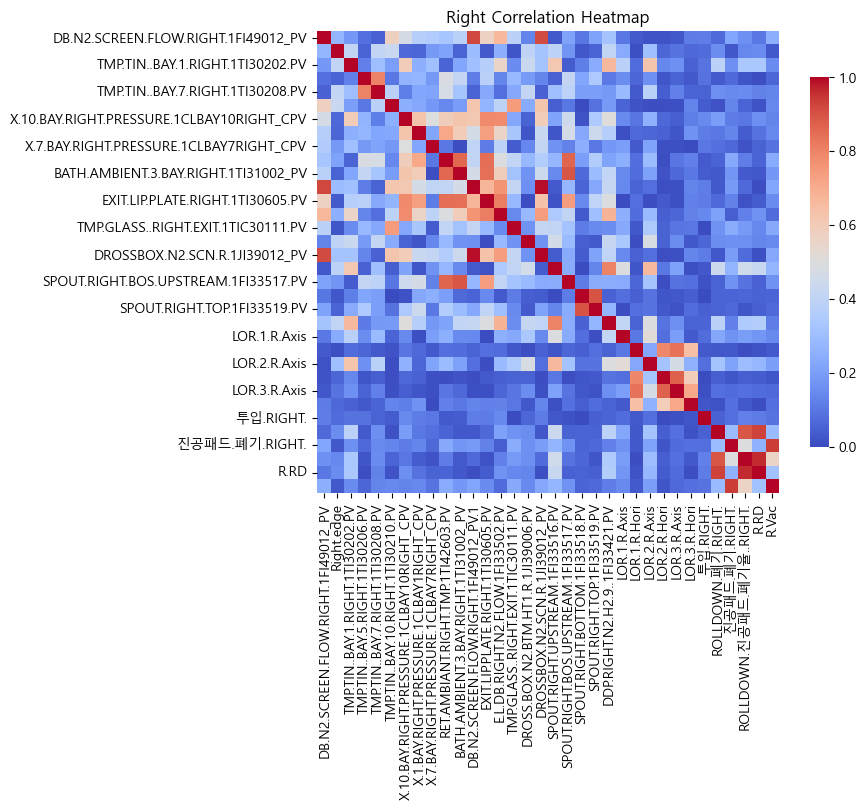

In [ ]:
# LEFT, RIGHT 개별 히트맵

# 왼쪽 상관 행렬 히트맵
left_preprocessed_df = preprocessed_df[left_cols]
left_corr = abs(left_preprocessed_df.corr())

plt.figure(figsize= (8, 6))
sns.heatmap(left_corr, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, vmin=0, vmax=1) # annot= True , fmt='.2f'
plt.title('Left Correlation Heatmap')
plt.gca().set_aspect('equal')

# 오른쪽 상관 행렬 히트맵
right_preprocessed_df = preprocessed_df[right_cols]
right_corr = abs(right_preprocessed_df.corr())

plt.figure(figsize= (8, 6))
sns.heatmap(right_corr, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, vmin= 0, vmax= 1)
plt.title('Right Correlation Heatmap')
plt.gca().set_aspect('equal')

plt.show()


In [45]:
# Left 히트맵 빈 부분 상수열 확인

constant_cols = [col for col in left_preprocessed_df.columns if left_preprocessed_df[col].nunique() == 1]
print(constant_cols)

costant_df = left_preprocessed_df[constant_cols]
costant_df.head()
costant_df.describe()

['TMP.TIN..BAY.4.LEFT.1TI30203.PV']


,TMP.TIN..BAY.4.LEFT.1TI30203.PV
count,8.143000e+03
mean,9.999387e-01
std,8.682477e-14
min,9.999387e-01
25%,9.999387e-01
50%,9.999387e-01
75%,9.999387e-01
max,9.999387e-01


## 2. LOWER 피쳐 제거

In [ ]:
# UPPER. , UP, _U_
# LOWER. , DOWN, _L_

In [51]:
# drop_right_df.columns.tolist()

### 2-1. Upper, Lower 상관관계 확인

In [72]:
# 1) upper, lower 쌍 상관 계수
upper_cols = preprocessed_df.filter(regex=r'\b(UPPER|UP|_U)\b').columns.tolist()
lower_cols = preprocessed_df.filter(regex=r'\b(LOWER|DOWN|_L)\b').columns.tolist()

# upper와와 lower 열을 매칭하기 위한 딕셔너리 생성
upper_lower_pairs = {}

# upper 열 이름 처리
for upper_col in upper_cols:
    # 숫자를 제외하고 동일한 열 쌍으로 생성
    process_id = re.sub(r'(UPPER|UP|_U|\d+)', '', upper_col, flags=re.IGNORECASE) # 수치를 제외한 나머지가 동일, re.IGNORECASE : 대소문자 구별없음
    if process_id not in upper_lower_pairs:
        upper_lower_pairs[process_id] = {'upper': upper_col, 'lower': None}
    else:
        upper_lower_pairs[process_id]['upper'] = upper_col

# RIGHT 열 이름 처리
for lower_col in lower_cols:
    process_id = re.sub(r'(LOWER|DOWN|_L|\d+)', '', lower_col, flags=re.IGNORECASE)
    if process_id not in upper_lower_pairs :
        upper_lower_pairs[process_id] = {'upper': None, 'lower': right_col}
    else:
        upper_lower_pairs[process_id]['lower'] = lower_col

upper_lower_pairs # dict {process_id : {'upper' : 'upper_process_id}, {'right' : 'lower_process_id}}

UL_correlation_results = []

for process_id, col in upper_lower_pairs.items():
    upper_col = col['upper']
    lower_col = col['lower']

    if upper_col in preprocessed_df.columns and lower_col in preprocessed_df.columns:
        correlation = preprocessed_df[upper_col].corr(preprocessed_df[lower_col])
        UL_correlation_results.append((upper_col, lower_col, correlation))

UL_correlation_results = sorted(UL_correlation_results, key=lambda x: abs(x[2]), reverse=True)
UL_correlation_results

[('UPPER.C4..Z203.TMP.1TIC42507.PV',
  'LOWER.C4..Z210.TMP.1TIC42557.PV',
  0.8578233841654308),
 ('UPPER.AB11.Z147.TMP.1TIC42107.PV',
  'LOWER.AB11.Z154.TMP.1TIC42157.PV',
  0.6834668751492626),
 ('UPPER.AB10.Z129TMP.1TIC42003.PV',
  'LOWER.AB4.Z55TMP.1TIC41456.PV',
  0.30298147353837945),
 ('N2.TO.HOOD.UP.STREAM.1FI33506A_PV',
  'N2.TO.HOOD.DOWN.STREAM.1FI33505A_PV',
  -0.05513710909737312)]

In [74]:
# 결과를 DataFrame으로 변환
UL_correlation_df = pd.DataFrame(UL_correlation_results, columns=['upper_col', 'lower_col', 'Correlation'])

# 쌍 상관계수 결과 확인
UL_correlation_df

correlation_drop_lower_cols = UL_correlation_df[abs(UL_correlation_df['Correlation']) >= 0.8]['lower_col'].tolist()
correlation_drop_lower_cols

['LOWER.C4..Z210.TMP.1TIC42557.PV']

### 2-2. Upper, Lower t-test

In [69]:
# upper_cols
# lower_cols

In [73]:
# p_value > 0.05 : 동일한 분포를 가질 가능성이 높음

UL_ttest_result = []

for u_col, l_col in zip(upper_cols, lower_cols):
    t_stat, p_value = ttest_ind(preprocessed_df[u_col].dropna(), preprocessed_df[l_col].dropna())
    UL_ttest_result.append((u_col, l_col, p_value))

UL_ttest_df = pd.DataFrame(UL_ttest_result, columns= ['upper_col', 'lower_col', 'p_value'])
UL_ttest_df

ttest_drop_lower_cols = UL_ttest_df[UL_ttest_df['p_value'] <= 0.05]['lower_col'].to_list()
ttest_drop_lower_cols


[]

In [76]:
# UL_ttest_df

### 2-3. 상관관계, t-test기반 열 삭제

In [ ]:
# drop list - correlation, ttest
print(len(correlation_drop_lower_cols)) # 1
print(len(ttest_drop_lower_cols)) # 0

total_drop_lower_cols = correlation_drop_lower_cols + ttest_drop_lower_cols
total_drop_lower_cols = set(total_drop_lower_cols)
print(total_drop_lower_cols)
print(len(total_drop_lower_cols)) # 1

drop_lower_df = drop_right_df.loc[:, ~drop_right_df.columns.isin(total_drop_lower_cols)]
drop_lower_df.info() #(8143, 817) num_col : 818 > 817

1
0
{'LOWER.C4..Z210.TMP.1TIC42557.PV'}
1
<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 817 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(814), int64(3)
memory usage: 50.8+ MB


### 2-4. Upper, Lower 개별 히트맵

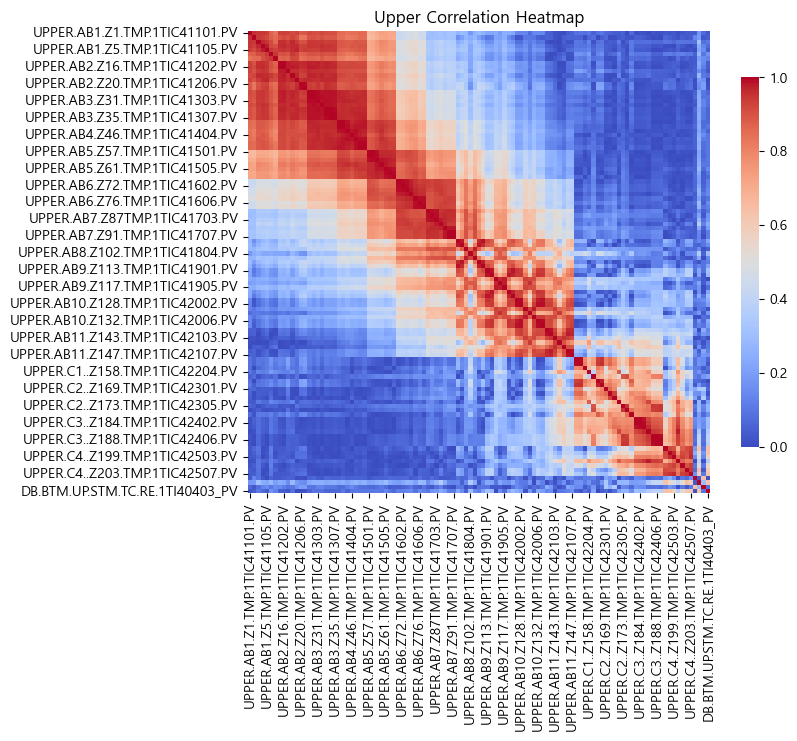

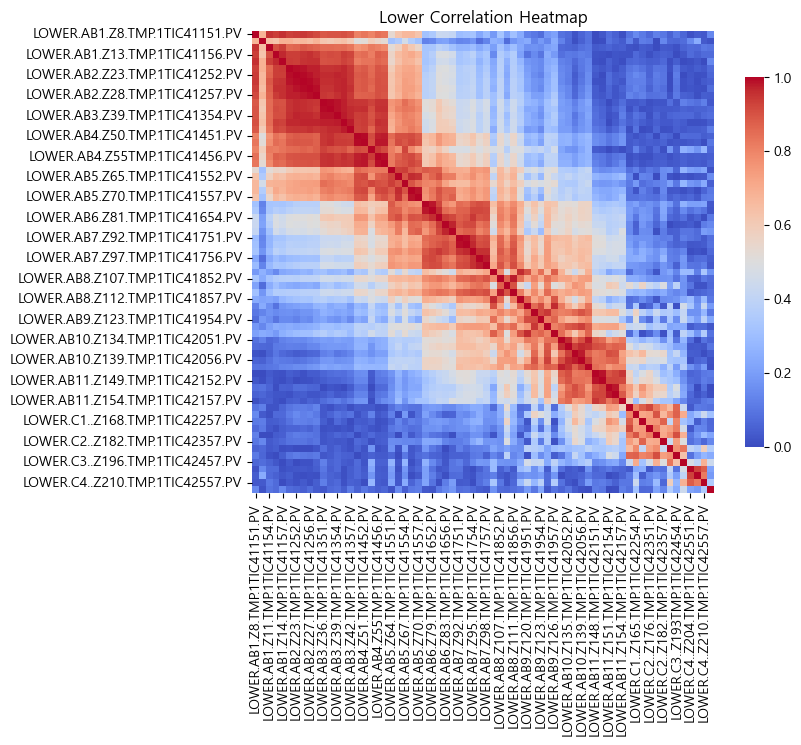

In [79]:
# Upper, Lower 개별 히트맵맵

# 상부 상관 행렬 히트맵
upper_preprocessed_df = preprocessed_df[upper_cols]
upper_corr = abs(upper_preprocessed_df.corr())

plt.figure(figsize= (8, 6))
sns.heatmap(upper_corr, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, vmin=0, vmax=1) # annot= True , fmt='.2f'
plt.title('Upper Correlation Heatmap')
plt.gca().set_aspect('equal')

# 하부 상관 행렬 히트맵
lower_preprocessed_df = preprocessed_df[lower_cols]
lower_corr = abs(lower_preprocessed_df.corr())

plt.figure(figsize= (8, 6))
sns.heatmap(lower_corr, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, vmin= 0, vmax= 1)
plt.title('Lower Correlation Heatmap')
plt.gca().set_aspect('equal')

plt.show()


## 3. 의미 없는 열 제거

### 3-1.  0.01 미만의 분산 열 제거

In [80]:
drop_lower_df.info() # (8143, 817)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 817 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(814), int64(3)
memory usage: 50.8+ MB


In [100]:
std_scaler = StandardScaler()
std_drop_lower_arr = std_scaler.fit_transform(drop_lower_df)

std_drop_lower_df = pd.DataFrame(std_drop_lower_arr, columns= drop_lower_df.columns, index= drop_lower_df.index)
std_drop_lower_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 817 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(817)
memory usage: 50.8+ MB


In [101]:
# 통상적으로 분산 0.01 이하의 데이터의 경우 '상수'라고 간주 - 도메인 지식과 상관 분석 필요
# 잘 관리되는 공정

variance_threshold = 0.01
low_variance_cols = [col for col in std_drop_lower_df.columns if std_drop_lower_df[col].var() < variance_threshold]
# print("분산이 작은 열:", low_variance_cols)

columns_to_drop = [col for col in low_variance_cols if col not in ['L.RD', 'L.Vac']]
columns_to_drop # 7개

['LEHR.DRV.MTR..M4.2.CUR.1WII40105.PV',
 'LEHR.DRV.MTR..M9.1.CUR.1WII40114.PV',
 'LEHR.DRV.MTR..M9.2.CUR.1WII40115.PV',
 'LEHR.DRV.MTR..M10.1.CUR.1WII40116.PV',
 'LEHR.DRV.MTR..M14.1.CUR.1WII40124.PV',
 'LEHR.DRV.MTR..M17.2.CUR.1WII40131.PV',
 'TMP.TIN..BAY.4.LEFT.1TI30203.PV']

In [102]:
drop_var_df = drop_lower_df.drop(columns=columns_to_drop) 
drop_var_df.info() # (8143, 810) num_col : 817 > 810

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 810 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(807), int64(3)
memory usage: 50.4+ MB


## 3-2. 다중 공선성 제거

- 변수 간 상관 계수 0.9이상 제거

- VIF 10이상 제거

In [ ]:
drop_var_df.info() # (8143, 810)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 810 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to L.Vac
dtypes: float64(807), int64(3)
memory usage: 50.4+ MB


In [103]:
feature_df = drop_var_df.drop(['L.RD', 'L.Vac'], axis= 1) # 808
target_df = drop_var_df[['L.RD', 'L.Vac']] # 2

In [104]:
# 상관 계수가 0.8이상인 변수 삭제 
corr_matrix = feature_df.corr().abs()  # 절댓값으로 상관계수 계산

# 0.8이상 596열
# 0.9이상 469열

high_corr_var = set()

for i in range(len(corr_matrix.columns)) : 
  for j in range(i) : # 자기 자신 계산 제외
    if corr_matrix.iloc[i, j] > 0.8 :
      colname= corr_matrix.columns[i]
      high_corr_var.add(colname)

len(high_corr_var)

# 삭제
X_drop_corr_df = feature_df.drop(high_corr_var, axis= 1)
X_drop_corr_df.info() # 808 > 212 : 596열 삭제

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 212 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to 폐기율...
dtypes: float64(209), int64(3)
memory usage: 13.2+ MB


In [89]:
# VIF 계산 함수 정의

def calculate_vif(X_df):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    vif['features'] = X_df.columns
    return vif.sort_values(by='VIF', ascending=False)

# 가장 높은 VIF를 가진 컬럼 del_num만큼 삭제하는 함수
def del_highest_vif_col(vif, X_df, del_num):
    highest_vif_col = vif.iloc[0:del_num]['features']
    X_df.drop(highest_vif_col, axis=1, inplace=True)
    return X_df

X_df = X_drop_corr_df.copy()
sorted_vif_df = calculate_vif(X_df)

# 미리 10개씩 삭제해 본 결과 109에서 멈춤
while len(sorted_vif_df[sorted_vif_df['VIF'] > 10]) > 0 :
    if len(sorted_vif_df[sorted_vif_df['VIF'] > 20]) > 0 :
        X_df = del_highest_vif_col(sorted_vif_df, X_df, 10)
    else :
        X_df = del_highest_vif_col(sorted_vif_df, X_df, 1)
    sorted_vif_df = calculate_vif(X_df) 
    # print(len(sorted_vif_df))

# 최종 결과 출력
print("최종 컬럼 개수:", X_df.shape[1]) # 117
print("최종 VIF 데이터프레임:")
print(sorted_vif_df)

# 38m

최종 컬럼 개수: 117
최종 VIF 데이터프레임:
          VIF                                 features
40   9.454312          DB.BTM.UP.STM.TC.RE.1TI40403_PV
95   9.422078                               D_AB4_L_UL
4    9.067666         ROOF.HEATING.Zone.1.1JIC31101.PV
43   9.042361      ROOF.HT.BAY.3.TOTAL.PWR.1CLBAY3_CPV
96   9.035635                               D_AB6_R_UL
82   8.995028                             lc_rc_btm_dn
81   8.989652                            r_tin_bay_5_7
2    8.939832       DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV
92   8.904199                              D_AB11_U_LR
27   8.634121             TMP.GLASS..BAY.1.1TI30101.PV
7    8.596263          ATM.FLOW.SECT.9.N2.1FIC33415.PV
53   8.372170         ROOF.HEATING.Zone45.1JIC31145.PV
38   8.325711       DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV
51   8.322391         ROOF.HEATING.Zone31.1JIC31131.PV
5    8.203225         ROOF.HEATING.Zone.2.1JIC31102.PV
9    8.183402            UPPER.AB1.Z1.TMP.1TIC41101.PV
100  8.099441                       

In [94]:
# X_df.info() # 321 > 110열(기존) # 212 > 117열 : 95열 삭제
# L.RD, L.Vac열도 삭제됨

drop_vif_df = X_df.copy()
drop_vif_df.info() # (8143, 117)
print()

target_df = preprocessed_df[['L.RD', 'L.Vac']]

drop_vif_full_df = pd.concat([drop_vif_df, target_df], axis= 1)
drop_vif_full_df.info() # (8143, 119)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 117 entries, X1WOS45106_PV to 폐기율...
dtypes: float64(114), int64(3)
memory usage: 7.3+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 119 entries, X1WOS45106_PV to L.Vac
dtypes: float64(116), int64(3)
memory usage: 7.5+ MB


In [128]:
feature_selection_df = drop_vif_full_df.copy()
feature_selection_df.to_csv('../data/feature_selection_df.csv', index= True) # (8143, 119)

## 4. 차원 축소 및 군집

In [108]:
# preprocessing_df.info()

X = feature_selection_df.iloc[:, :-2]
y = feature_selection_df.iloc[:, -2:]
X.shape # (8143, 117)

(8143, 117)

In [ ]:
# gmm / bgmm은 고차원 데이터에서 차별화가 약해짐 - PCA 수행

pca = PCA(n_components= 0.90) 
X_pca = pca.fit_transform(X)

pca.n_components_ # 90% : 17개의 피쳐, 95% : 38개의 피쳐로 설명 가능
X_pca.shape

(8143, 17)

In [127]:
baysian_gmm = BayesianGaussianMixture(n_components= 5, random_state= 42).fit(X_pca) # 7 > 6 > 5
print(np.round(baysian_gmm.weights_, 2))

[0.36 0.03 0.19 0.1  0.31]


In [129]:
X_bgm = baysian_gmm.predict_proba(X_pca)

bgm_df = pd.DataFrame(X_bgm, columns=[f'bgm_predict_proba_{i}' for i in range(X_bgm.shape[1])], index= feature_selection_df.index)
bgm_df.info()
bgm_df[:5]

feature_extraction_df = pd.concat([X, bgm_df, y], axis= 1)
feature_extraction_df.info() # (8143, 124) : 117+5+2

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bgm_predict_proba_0  8143 non-null   float64
 1   bgm_predict_proba_1  8143 non-null   float64
 2   bgm_predict_proba_2  8143 non-null   float64
 3   bgm_predict_proba_3  8143 non-null   float64
 4   bgm_predict_proba_4  8143 non-null   float64
dtypes: float64(5)
memory usage: 381.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 124 entries, X1WOS45106_PV to L.Vac
dtypes: float64(121), int64(3)
memory usage: 7.8+ MB


In [130]:
feature_extraction_df.to_csv('../data/feature_extraction_df.csv', index= True)

## 5. Robust Scaler

In [133]:
# 이상치 유지
robust_scaler = RobustScaler()

scaled_arr = robust_scaler.fit_transform(feature_selection_df)
scaled_df = pd.DataFrame(scaled_arr, columns= feature_selection_df.columns, index= feature_selection_df.index)

scaled_df = pd.concat([scaled_df, bgm_df], axis= 1)

In [134]:
scaled_df.info()
scaled_df.to_csv('../data/scaled_df.csv', index= True) # (8143, 124)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 124 entries, X1WOS45106_PV to bgm_predict_proba_4
dtypes: float64(124)
memory usage: 7.8+ MB


In [ ]:
# 데이터프레임 3개
# 1. feature_selection : 피쳐 제거(다중 공선성, 상관계수, 오른쪽,하단부 공정) - (8143, 119)
# 2. feature_extraction : PCA후 BGMM으로 군집 확률로 변수화 - (8143, 124)
# 3. scaled_df : 1+2 후 Robust scaler로 스케일링함 - (8143, 124)